# Laboratory LCA of Hydrothermal Carbonization  
This Jupyter notebook is for conducting an explaratory life cycle accessment (LCA) analysis to identify areas of sensitivity and further determine the optimal conditions for upscaling hydrothermal carbonization (HTC) under deep uncertainty. This notebook is organized in three sections: 
1) Project Setup: Importing main packages & ecoinvent databases 
2) Baseline LCA Model: Developing a baseline LCA model for evaluating environmental impacts, in the form of carbon,  for basic scenarios. 
3) Uncertainty Analysis: Performing a Monte Carlo simulation as a method of exploring optimal conditions for HTC to consider upon upscaling & futrue decision making, in consideration of lab-scale data uncertainty, utilizing a deterministic model.  

This notebook serves as a supplementary analysis to ____

## 1: Project Setup
Installing required packages, setting up projects, and importing ecoinvent databases. Be sure to activate the virtual environment and install requirements.txt.  

In [1]:
# Installing main packages
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

In [2]:
# Importing BW2 packages
import brightway2 as bw
from bw2data.parameters import ProjectParameter, ParameterManager, ActivityParameter

In [3]:
# Import BW25 packages. 
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa

In [4]:
# Creating a new project: HTC-uncertainty 
bd.projects.set_current('HTC-uncertainty')

In [5]:
# Installing biosphere flows 
bi.bw2setup()

Creating default biosphere

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applying strategy: ensure_categories_are_tuples
Applied 3 strategies in 0.00 seconds


100%|██████████| 4709/4709 [00:00<00:00, 11454.52it/s]


Vacuuming database 
Created database: biosphere3
Creating default LCIA methods

Wrote 762 LCIA methods with 227223 characterization factors
Creating core data migrations



In [5]:
# Getting main folder with ecoinvent files. Replace this with your own directory.  
def get_ecoinvent_directory(): 
    return "../../ecoinvent_v3.10"

In [6]:
def write_data(ei_path, ei_name): 
    if ei_name in bd.databases:
        print("Database has already been imported.")
    else:
        ei_importer = bi.SingleOutputEcospold2Importer(ei_path, ei_name, use_mp = False)
        # Should you have a problem with "unlinked exchanges"
        try: 
            ei_importer.add_unlinked_flows_to_biosphere_database() 
        except Exception as e:
            print(f"An error occurred: {e}")
        ei_importer.apply_strategies()
        ei_importer.statistics()
        ei_importer.write_database()
        print(str(ei_name) + " database is completed!")

In [7]:
def create_databases():
    for folder in os.listdir(get_ecoinvent_directory()):
        folder_path = os.path.join(get_ecoinvent_directory(), folder + "/datasets")
        # Only using cutoff for this analysis 
        if os.path.isdir(folder_path) and 'cutoff' in folder:
            write_data(folder_path, folder_path.split('\\')[-1])
    print(bd.databases)

In [12]:
create_databases()

100%|██████████| 23523/23523 [18:19<00:00, 21.40it/s] 


Extracted 23523 datasets in 1104.73 seconds


100%|██████████| 5769/5769 [00:00<00:00, 9935.22it/s] 


Vacuuming database 
Applying strategy: link_iterable_by_fields
Applying strategy: normalize_units
Applying strategy: update_ecoinvent_locations
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: fix_ecoinvent_flows_pre35
Applying strategy: drop_temporary_outdated_biosphere_flows
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_internal_technosphere_by_composite_code
Applying strategy: delete_exchanges_missing_activity
Applying strategy: delete_ghost_exchanges
Applying strategy: remove_uncertainty_from_negative_loss_exchanges
Applying strategy: fix_unreasonably_high_lognormal_uncertainties
Applying strategy: convert_activity_pa

100%|██████████| 23523/23523 [03:36<00:00, 108.79it/s]


Vacuuming database 
Created database: cutoff/datasets
cutoff/datasets database is completed!
Databases dictionary with 2 object(s):
	biosphere3
	cutoff/datasets


In [8]:
# Ensuring cutoff database has been imported correctly
bd.databases

Databases dictionary with 2 object(s):
	biosphere3
	cutoff/datasets

In [9]:
# Creating database reference to not override or intefere with cutoff model: 
eidb = bd.Database("cutoff/datasets")

In [10]:
# Creating database reference to not override or intefere with the biosphere model: 
biosphere3 = bw.Database('biosphere3')

In [11]:
# Checking for proper replication: 
print("The imported ecoinvent database is of type {} and has a length of {}.".format(type(eidb), len(eidb)))

The imported ecoinvent database is of type <class 'bw2data.backends.base.SQLiteBackend'> and has a length of 23541.


In [12]:
# Checking for proper replication of biosphere database 
print("The biosphere database is of type {} and has a length of {}.".format(type(biosphere3), len(biosphere3)))

The biosphere database is of type <class 'bw2data.backends.base.SQLiteBackend'> and has a length of 5769.


## 2: Baseline LCA
Conducting a baseline LCA, as a foreground system for determining environmental impacts for main feedstocks based on numerical averages. The feedstocks of interest are as follows:  
 - SRU Feedstock with water to reach an 85% moisture content
 - BSG Feedstock with water to reach at 85% moisture content
 - DCW Feedstock (already above 85% moisture content; no additional water needed)

### 2.1: Identifying Appropriate Flows
All hydrothermal carbonization models have the following inputs: 
1) Feedstock: It will be assumed that the feedstock is a waste product and has no corresponding environmental impacts. The process of transporting food waste is not considered for this analysis.  
2) Water: If needed, water is added to reach a moisture content. If not needed, water is 0. 
3) Electricity: Needed for stirring of an HTC reaction & for post-processing. 
4) Heat: Needed for the HTC reaction and post-processing steps. 
It will be assumed that the equipment itself has a long lifetime and any pre-processing for the equipment or environmental impacts for setting up or maintaining a system will not be explored in this analysis. 

Simultaneously, all hydrothermal carbonization models have the following outputs: 
1. Hydrochar (functional unit): The goal of this analysis is to determine the optimal method for producing a solid hydrochar (HC).  
2. Carbon Dioxde: Gas yields from HTC are assumed to be pure CO<sub>2</sub> are emitted to the atmosphere. 
3. Wastewater: Process Water from the HTC process that requires treatment at a wastewater treatment plant. 

In [13]:
# Searching for Electricity
for act in [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']]:
    print(act)

'market group for electricity, low voltage' (kilowatt hour, US, None)


In [14]:
# Assuming Heat uses the same source as electricity, based on Parr reactor specifications
# https://www.parrinst.com/products/stirred-reactors/series-4520-1-2l-bench-top-reactors/specifications/

for act in [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']]:
    print(act)

'market group for electricity, low voltage' (kilowatt hour, US, None)


In [15]:
# Searching for Water 
for act in [act for act in eidb if 'market for water, completely softened' in act['name']  and 'US' in act['location']]:
    print(act)

'market for water, completely softened' (kilogram, US, None)


In [16]:
# Searching for Wastewater 
for act in [act for act in eidb if 'treatment of wastewater, average, wastewater treatment' in act['name']  and 'RoW' in act['location']]:
    print(act)

'treatment of wastewater, average, wastewater treatment' (cubic meter, RoW, None)


In [17]:
# Searching for Carbon Dioxide Stream; in this case the second option is of interest.  
for flow in [flow for flow in biosphere3 if 'carbon dioxide, non-fossil, resource correction' in flow['name'].lower()]:
    print(flow)

'Carbon dioxide, non-fossil, resource correction' (kg, None, None)
'Carbon dioxide, non-fossil, resource correction' (kilogram, None, ('natural resource', 'in air'))


### 2.2: Setting Up Product System
Creating product systems for main feedstocks

In [18]:
from feedstock import Feedstock, FeedstockManager, create_elementary_feedstocks
from model import get_feedstock_quantity, get_water_quantity, get_heat_needed, get_electricity_needed
from model import  get_co2_emissions, get_pw, get_parameter, get_post_processing

In [19]:
# If needed, delete existing parameters
for item in ProjectParameter.select(): 
    item.delete()

ProjectParameter.drop_table(safe=True, drop_sequences=True)
# create a new empty table of project parameters
ProjectParameter.create_table()

for name in ProjectParameter.select():
    name.print()

In [20]:
# If needed, delete existing activities
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    act.delete()
    
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    print(act)

In [21]:
# Re initializing elementary feedstocks if needed
elementary_feedstocks = create_elementary_feedstocks()

In [22]:
# Creating Activities for Different Feedstocks 
excluded_feedstocks = {"rawSRU", "rawBSG"}
for attr, feedstocks in elementary_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        if feedstock.name not in excluded_feedstocks:
            # for temp in HTC_temp:
            #     for time in HTC_reaction_time:
            temp = feedstock.temp
            time = feedstock.time 
            hydrochar_production = eidb.new_activity(
                code=f'HTC_{feedstock.name}_{temp}C_{time}hr',
                name=f"hydrochar production, {feedstock.name}_{temp}C_{time}hr",
                location='US',
                unit="kg"
            )
            parameters = ParameterManager()
            yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield')
            gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'gas_yield')
            project_data = [
                {
                    'name': 'feedstock_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
                    'amount': get_feedstock_quantity(yield_HC, feedstock)
                }, 
                {
                    'name': 'water_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
                    'amount': get_water_quantity(yield_HC, feedstock)
                }, 
                {
                    'name': 'heat_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
                    'amount': get_heat_needed(feedstock, temp, time)
                },
                {
                    'name': 'electricity_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
                    'amount': get_electricity_needed(feedstock, time, temp)
                }, 
                {
                    'name': 'co2_' + f'HTC_{feedstock.name}_{temp}C_{time}hr',
                    'amount': get_co2_emissions(yield_HC, gas_yield, feedstock)
                }, 
                {
                    'name': 'wastewater_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
                    'amount': get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
                },
                {
                    'name': 'post_processing_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
                    'amount': get_post_processing(hc_placeholder=1)
                }
            ]
            
            print(project_data)
            parameters.new_project_parameters(project_data)
            
            # for param in ProjectParameter.select():
            #     print(param, param.amount)
            
            # Feedstock 
            hydrochar_production.new_exchange(input=('biosphere3', 'feedstock'), amount=0, unit="kg", type='custom', formula= 'feedstock')
            hydrochar_production.save()
                                
            # Water 
            water = [act for act in eidb if 'market for water, completely softened' in act['name']  and 'US' in act['location']][0]
            hydrochar_production.new_exchange(input=water.key, amount=0, unit="kilogram", type='technosphere', 
                                                formula= 'water_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
            hydrochar_production.save()
            
            # Electricity
            electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
            hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                                formula='electricity_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
            hydrochar_production.save()
            
            # Heat 
            electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
            hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                                formula='heat_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
            hydrochar_production.save()
            
            # CO2 Emissions
            co2 = [flow for flow in biosphere3 if 'carbon dioxide, non-fossil, resource correction' in flow['name'].lower()][1]
            hydrochar_production.new_exchange(input=co2.key, amount=0, unit="kilogram", type='biosphere', 
                                                formula='-1*co2_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
            hydrochar_production.save()
            
            # Wastewater 
            wastewater = [act for act in eidb if 'treatment of wastewater, average, wastewater treatment' in act['name']  and 'RoW' in act['location']][0]
            hydrochar_production.new_exchange(input=wastewater.key, amount=0, unit="cubic meter", type='technosphere', 
                                                formula='-1*wastewater_' + f'HTC_{feedstock.name}_{temp}C_{time}hr/1000').save()
            hydrochar_production.save()
            
            # Post-Processing
            electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
            hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                                formula='post_processing_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
            hydrochar_production.save()
            
            parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", hydrochar_production)
            ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr")
            print()        

[{'name': 'feedstock_HTC_stdSRU_190C_1hr', 'amount': 4.405149378057423}, {'name': 'water_HTC_stdSRU_190C_1hr', 'amount': 1.4013095047525619}, {'name': 'heat_HTC_stdSRU_190C_1hr', 'amount': 1.802243989661737}, {'name': 'electricity_HTC_stdSRU_190C_1hr', 'amount': 0.052881176818981995}, {'name': 'co2_HTC_stdSRU_190C_1hr', 'amount': 0.013643627895201066}, {'name': 'wastewater_HTC_stdSRU_190C_1hr', 'amount': 4.792815254914784}, {'name': 'post_processing_HTC_stdSRU_190C_1hr', 'amount': 28.815}]

[{'name': 'feedstock_HTC_stdSRU_190C_3hr', 'amount': 3.902283644770988}, {'name': 'water_HTC_stdSRU_190C_3hr', 'amount': 1.2413443205572885}, {'name': 'heat_HTC_stdSRU_190C_3hr', 'amount': 3.9700552622566088}, {'name': 'electricity_HTC_stdSRU_190C_3hr', 'amount': 0.12378628909107907}, {'name': 'co2_HTC_stdSRU_190C_3hr', 'amount': 0.019413962826294342}, {'name': 'wastewater_HTC_stdSRU_190C_3hr', 'amount': 4.124214002501982}, {'name': 'post_processing_HTC_stdSRU_190C_3hr', 'amount': 28.815}]

[{'name'

In [23]:
# Cross Checking Exchanges 
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    print(act)
    for exc in act.exchanges():
        print(exc)
    print()

'hydrochar production, stdBSG_250C_1hr' (kg, US, None)
Exchange: 3.203986984903217 kilogram 'market for water, completely softened' (kilogram, US, None) to 'hydrochar production, stdBSG_250C_1hr' (kg, US, None)>
Exchange: 0.07217586728748893 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, US, None) to 'hydrochar production, stdBSG_250C_1hr' (kg, US, None)>
Exchange: 2.944869962466106 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, US, None) to 'hydrochar production, stdBSG_250C_1hr' (kg, US, None)>
Exchange: -0.09521741729206844 kilogram 'Carbon dioxide, non-fossil, resource correction' (kilogram, None, ('natural resource', 'in air')) to 'hydrochar production, stdBSG_250C_1hr' (kg, US, None)>
Exchange: -0.008793528223363769 cubic meter 'treatment of wastewater, average, wastewater treatment' (cubic meter, RoW, None) to 'hydrochar production, stdBSG_250C_1hr' (kg, US, None)>
Exchange: 28.815 kilowatt hour 'market group for electricity,

### 2.3: Life Cycle Impact Assessment
Conducting Life Cycle Impact Assessments for baseline product systems. 

#### 2.3.1: Testing Baseline LCIA 
Ensuring that Life Cycle Impact Assessments work with Brightway2.5 for one impact category & one metric. 

In [24]:
method_key = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
activity = [act for act in eidb if 'hydrochar production' in act['name']][5]
functional_unit = { activity:1e-3}

In [25]:
lca = bw.LCA(functional_unit, method_key)

In [26]:
lca.lci()
lca.lcia()

In [27]:
lca.demand

{29302: 0.001}

In [28]:
lca.method

('TRACI v2.1 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [29]:
print("The {} process accounts for {:f} {}.".format(
    list(functional_unit.keys())[0]['name'],
    lca.score,
    bw.methods.get(method_key).get('unit')
    ))

The hydrochar production, rawDCW_220C_3hr process accounts for 0.023220 kg CO2-Eq.


In [30]:
exchange_contributions = []
total_impact = lca.score
for exc in activity.exchanges():
    # Create a temporary LCA object for each exchange
    temp_lca = bw.LCA({exc.input: exc['amount']}, method_key)
    print(exc.input)
    if 'Carbon dioxide' in str(exc.input): 
        pass
    else: 
        temp_lca.lci()
        temp_lca.lcia()
        
        # Calculate the contribution of this exchange
        contribution = temp_lca.score
        
        # Store the result
        exchange_contributions.append({
            'exchange': exc,
            'contribution': contribution,
            'percentage': (contribution * 0.001 / total_impact) * 100
        })

# Print the results
for result in exchange_contributions:
    print(f"Exchange: {result['exchange']}")
    print(f"Contribution: {result['contribution']:.4f}")
    print(f"Percentage of total impact: {result['percentage']:.2f}%")
    print('-' * 40)

'market for water, completely softened' (kilogram, US, None)
'market group for electricity, low voltage' (kilowatt hour, US, None)
'market group for electricity, low voltage' (kilowatt hour, US, None)
'Carbon dioxide, non-fossil, resource correction' (kg, None, None)
'treatment of wastewater, average, wastewater treatment' (cubic meter, RoW, None)
'market group for electricity, low voltage' (kilowatt hour, US, None)
Exchange: Exchange: 0.0 kilogram 'market for water, completely softened' (kilogram, US, None) to 'hydrochar production, rawDCW_220C_3hr' (kg, US, None)>
Contribution: 0.0000
Percentage of total impact: 0.00%
----------------------------------------
Exchange: Exchange: 0.5418962231053955 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, US, None) to 'hydrochar production, rawDCW_220C_3hr' (kg, US, None)>
Contribution: 0.2681
Percentage of total impact: 1.15%
----------------------------------------
Exchange: Exchange: 17.48422960332 kilowatt hour 'mar

#### 2.3.2: Developing Baseline LCA Models & Saving Data
Given that the baseline LCIA model has worked for one category for one process of producing hydrochar, repeat the process for all of the different baseline models and save to an Excel worksheet. 

In [31]:
# Identifying Life Cycle Impact Assessment Methods of Interest
methods = []
methods.append([m for m in bw.methods if 'ReCiPe 2016 v1.03, midpoint (H)' in str(m) and 'no LT' in str(m) and 'water use' in str(m)][0])
methods.append([m for m in bw.methods if 'ReCiPe 2016 v1.03, midpoint (H)' in str(m) and 'no LT' in str(m) and 'energy resources' in str(m)][0])
for method in [m for m in bw.methods if 'TRACI' in str(m) and 'no LT' in str(m)]: 
    methods.append(method)

In [32]:
from lcia import HydrocharLCIA, HydrocharLCIAManager, export_hydrochar_lcia_to_excel

In [33]:
def get_impact_category(method) -> str:
    '''Returns the corresponding impact assessment method name for modifying HydrocharLCIA given a Brightway LCIA method''' 
    if 'energy resource' in method[1]:
        return 'energy_resources'
    elif 'non-carcinogenic' in method[1]:
        return 'human_toxicity_noncarcinogenic'
    else: 
        method_name = (method[1].split('no LT')[0]).rstrip().replace(':', '_')
        method_name  = method_name.replace(' ', '_')
        method_name  = method_name.replace('__', '_')
        return method_name

In [34]:
baseline_lcia_manager = HydrocharLCIAManager()
# Functional Unit: 1g or 0.001kg
scaling_factor = 0.001 
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']


for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    activity_lcia = HydrocharLCIA(act['name'])
    for method in methods:
        impact_category = get_impact_category(method)
        method_key = method
        unit = bw.methods.get(method_key).get('unit')
        
        for i in range(len(process_categories)):
            process_catgeory = process_categories[i]
            exc = [exc for exc in act.exchanges()][i]
                
            functional_amount = exc['amount'] * scaling_factor
            functional_unit = { exc.input: functional_amount}
            temp_lca = bw.LCA(functional_unit, method_key)
            
            if 'Carbon dioxide' in str(exc.input) and 'climate change' in str(method_key):
                activity_lcia.set_impact_score(impact_category, process_catgeory, -1*functional_amount, unit)
                
            elif 'Carbon dioxide' in str(exc.input):
                activity_lcia.set_impact_score(impact_category, process_catgeory, 0, unit)
            
            else:
                temp_lca.lci()
                temp_lca.lcia()
                # print(exc.input, str(temp_lca.score) + str(unit))
                activity_lcia.set_impact_score(impact_category, process_catgeory, temp_lca.score, unit)
    
    baseline_lcia_manager.add_hydrochar(activity_lcia)
    print(activity_lcia.name , "successfully calculated & added to baseline LCIA Manager.")
    

hydrochar production, rawDCW_190C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, rawDCW_250C_1hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, rawDCW_220C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdSRU_190C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdSRU_190C_1hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, rawDCW_190C_1hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdBSG_220C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, rawDCW_250C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdBSG_250C_1hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdSRU_220C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdSRU_250C_3hr su

In [35]:
def export_hydrochar_lcia_to_excel(baseline_lcia_manager, exchange_names, input_names, file_path):
    
    # Create an Excel writer object with the xlsxwriter engine
    with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
        # Iterate through each hydrochar in the baseline_lcia_manager
        # for attr, lcia in baseline_lcia_manager.__dict__.items():
        hydrochar_lcia_list = sorted([hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia], key=lambda x: x.name)
        for hydrochar in hydrochar_lcia_list:
            # Create a dataframe for the hydrochar LCIA
            sheet_name = hydrochar.name.split('hydrochar production, ')[1]
            data = []

            # Row 1: Two blank cells followed by exchange names
            data.append(['', '', *exchange_names])
            
            # Row 2: Two blank cells followed by input names
            data.append(['', '', *input_names])
            
            # Row 3: First cell filled with 'Impact Assessment Method'
            data.append(['Impact Assessment Method'])
            
            # Fill other rows with impact assessment data
            impact_categories = [
                'water_use', 'energy_resources', 'acidification', 'climate_change',
                'ecotoxicity_freshwater', 'eutrophication', 'human_toxicity_carcinogenic',
                'human_toxicity_noncarcinogenic', 'ozone_depletion',
                'particulate_matter_formation', 'photochemical_oxidant_formation'
            ]
            
            for category in impact_categories:
                method_name = category.replace('_', ' ').title()
                method_unit = ""
                impact_data = getattr(hydrochar, category)
                for process_category in impact_data:
                    unit = impact_data[process_category]['unit']
                    if unit:
                        method_unit = unit
                        break
                
                row = [method_name, method_unit]
                for process_category in process_categories:
                    row.append(float('{:.2e}'.format(impact_data[process_category]['score'])))
                    # print(process_category)
                    # print(impact_data[process_category])
                data.append(row)
            
            df = pd.DataFrame(data)
            
            # Write dataframe to Excel sheet
            df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)

In [37]:
# Identifying Exchanges of Interest 
exchange_names = []
activity = [act for act in eidb if 'hydrochar production' in act['name']][0]
for exc in activity.exchanges(): 
    exchange_names.append(exc.input)
    
# Gathering Process Categories  
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']

# Writing Data to an Excel File 
export_hydrochar_lcia_to_excel(baseline_lcia_manager, exchange_names, process_categories, 'baseline-lcia/baseline_lcia.xlsx')

#### 2.3.3: Plotting Functional Unit Baseline LCA Results 
Plotting baseline LCA results standardized to the functional unit of 1 gram of hydrochar produced. 

In [38]:
# Making Figures 
def plot_stacked_bar_impact(baseline_lcia_manager, impact_category):
    # Extract all HydrocharLCIA objects from the baseline_lcia_manager
    hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]

    # Extract labels from the HydrocharLCIA objects
    labels = sorted([hc.name.split('hydrochar production, ')[1] for hc in hydrochar_lcia_list])

    # Prepare data for the plot
    process_categories = sorted(['Water', 'Heat-HTC', 'Electricity - HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing'])
    data = {process: [] for process in process_categories}
    units = None

    for hc in hydrochar_lcia_list:
        impact_data = getattr(hc, impact_category)
        for process in process_categories:
            score = impact_data[process]['score']
            unit = impact_data[process]['unit']
            data[process].append(score)
            if not units:
                units = unit

    # Convert data to a NumPy array for easier manipulation
    data_matrix = np.array([data[process] for process in process_categories])

    # Sort the data to have the highest impacts on the bottom
    sorted_indices = np.argsort(data_matrix.sum(axis=1))[::-1]
    sorted_data_matrix = data_matrix[sorted_indices]
    sorted_process_categories = np.array(process_categories)[sorted_indices]

    # Plotting the stacked bar chart
    fig, ax = plt.subplots(figsize=(10, 7))
    bottom = np.zeros(len(hydrochar_lcia_list))

    for i, process in enumerate(sorted_process_categories):
        scores = sorted_data_matrix[i]
        ax.bar(labels, scores, bottom=bottom, label=process)
        bottom += scores

    # Adding labels and title
    ax.set_xlabel('Feedstock & Reactor Conditions')
    ax.set_ylabel(f'Total Impact per gram hydrochar produced ({units})')
    ax.set_title(f'Total {impact_category.replace("_", " ").title()} Impact per Feedstock & HTC Conditions')
    ax.legend()

    # Adding total impact labels on the bars in scientific notation
    for i, total in enumerate(bottom):
        formatted_total = f'{total:.1e}'.replace('e-0', 'e-').replace('e+0', 'e')
        ax.text(i, total, f'{formatted_total}', ha='center', va='bottom')

    # Set y-axis to be twice the size of the greatest bar graph value
    ax.set_ylim(0, bottom.max() * 1.5)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


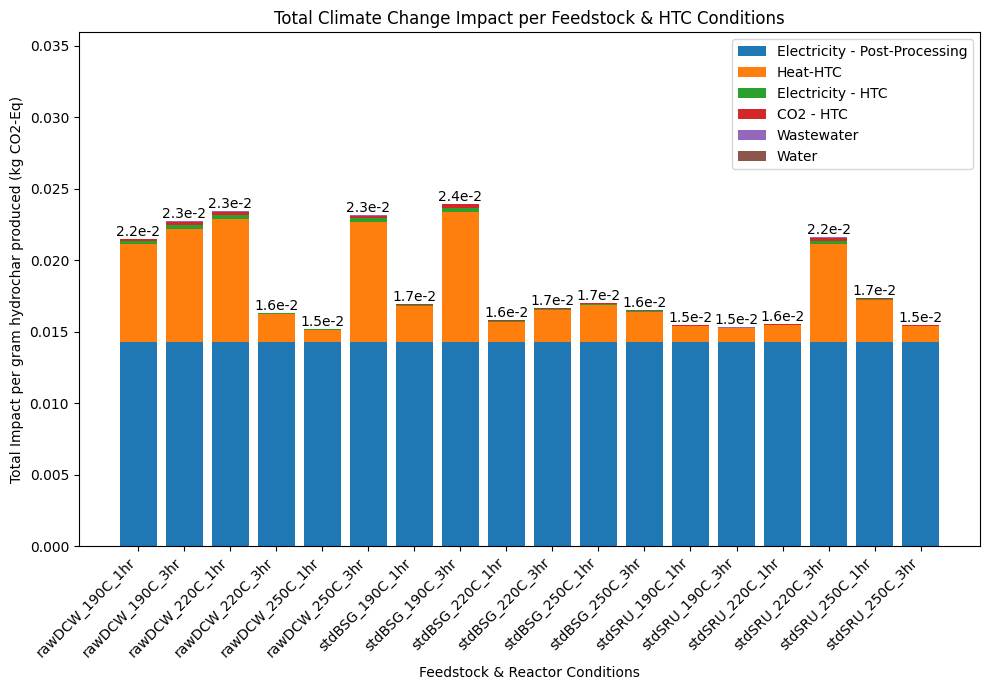

In [39]:
plot_stacked_bar_impact(baseline_lcia_manager, 'climate_change')

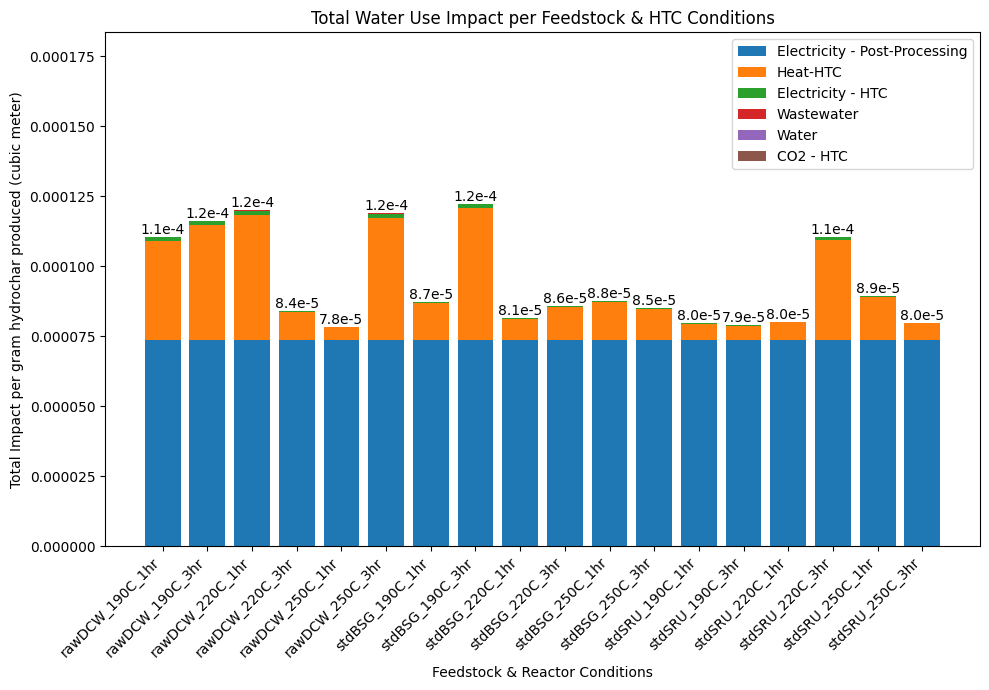

In [40]:
plot_stacked_bar_impact(baseline_lcia_manager, 'water_use')

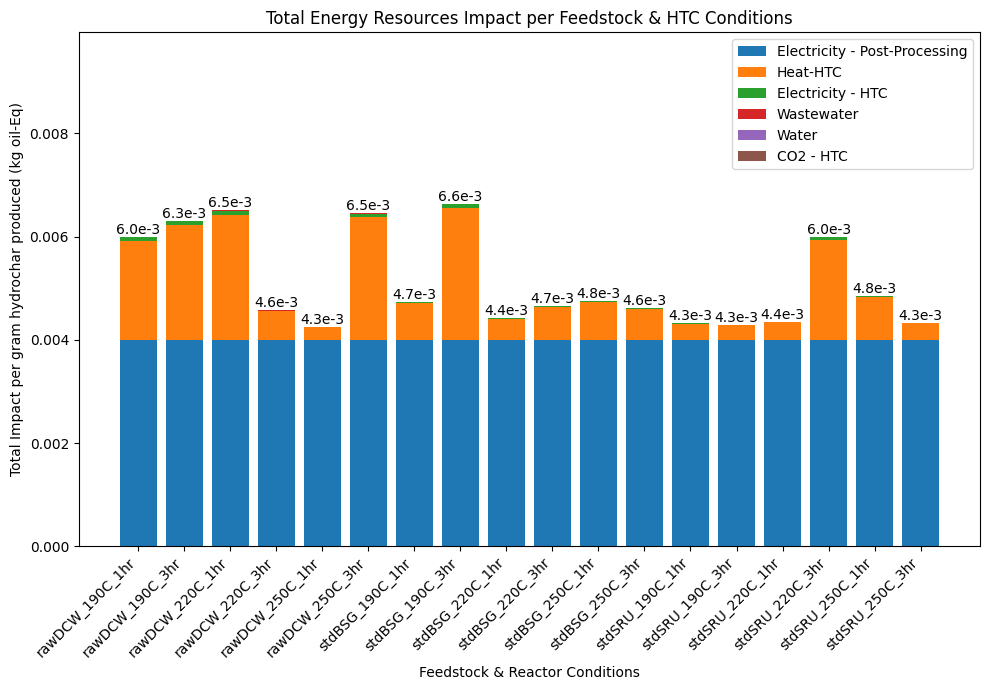

In [41]:
plot_stacked_bar_impact(baseline_lcia_manager, 'energy_resources')

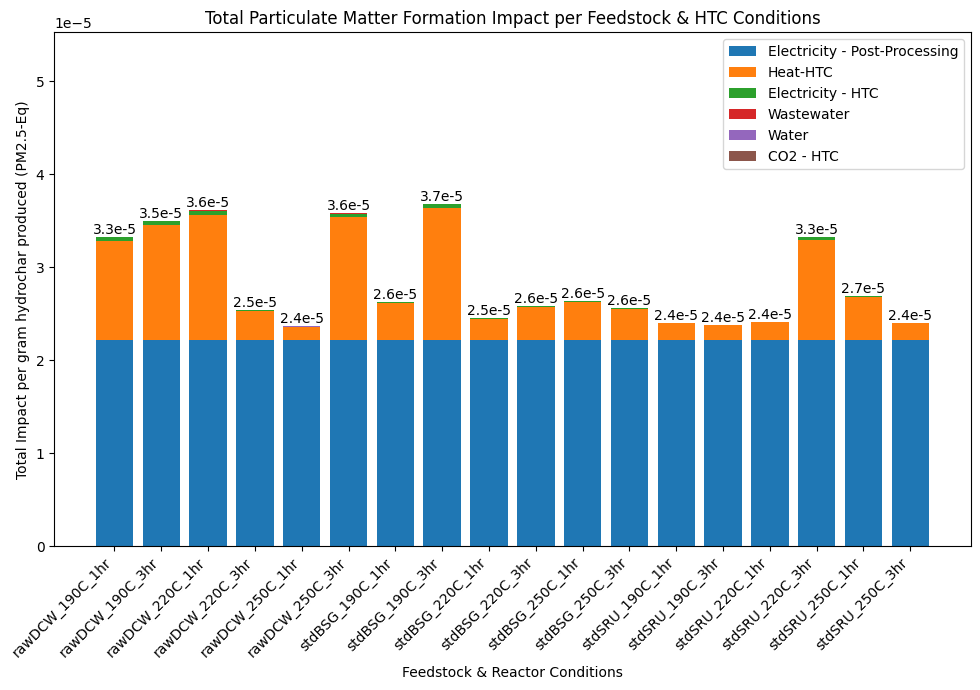

In [42]:
plot_stacked_bar_impact(baseline_lcia_manager, 'particulate_matter_formation')

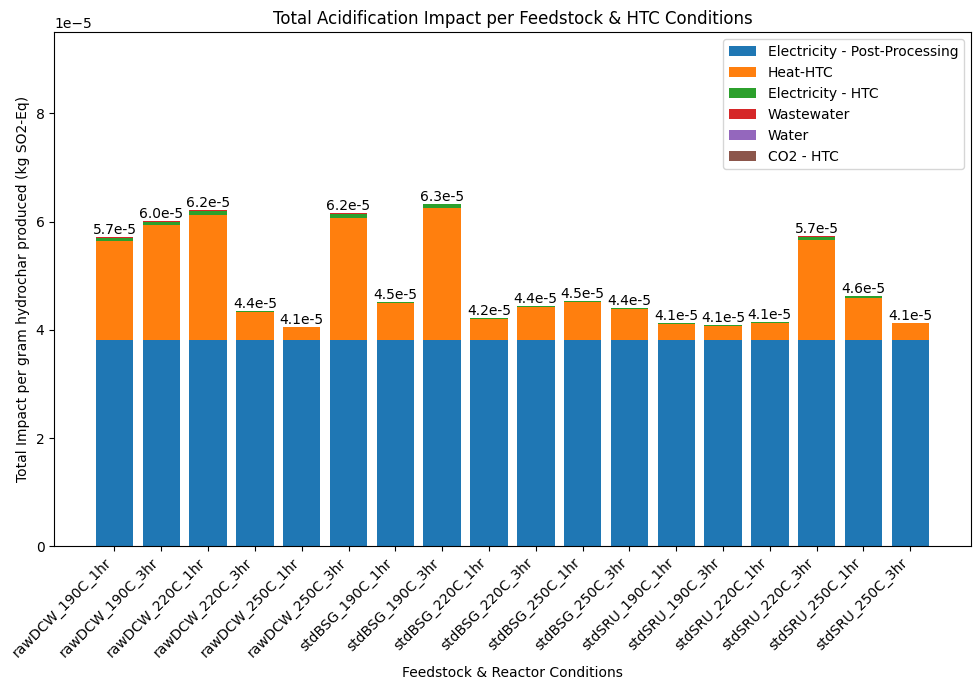

In [43]:
plot_stacked_bar_impact(baseline_lcia_manager, 'acidification')

#### 2.3.4: Plotting Feedstock Normalized Baseline LCA Results 
Plotting baseline LCA results normalized to per 500 grams of feedstock utilized. Note that difference that appears due to solely utilizing the quantity of the feedstock, as compared to the production of hydrochar. 

In [44]:
# Replicating Baseline LCIA Manager for Re-Use
feedstock_lcia_manager = copy.deepcopy(baseline_lcia_manager)
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
for lcia in feedstock_lcia_list: 
    
    # Getting Relevant Feedstock 
    activity = [act for act in eidb if str(lcia.name) in act['name']][0]
    feedstock_decomposed = activity['name'].split('hydrochar production, ')[1].split('_')
    feedstock_name, temp, time = feedstock_decomposed[0], int(feedstock_decomposed[1][0:3]), int(feedstock_decomposed[2][0])
    
    # Getting Feedstock Quantity 
    feedstock = elementary_feedstocks.get_feedstock(feedstock_name, temp, time)
    
    # Determine normalization factor for getting per feedstock LCIA results
    # LCIA/feedstock = (LCIA / g hydrochar) * (g hydrochar / g feedstock) 
    normalization_factor = 1 / feedstock.quantity
    
    # Alternatively impact_categories = [attr for attr in lcia.__dict__ if attr != 'name']
    impact_categories = lcia.get_impact_categories()
    
    # Alternatively process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
    process_categories = lcia.get_process_categories()
    
    for impact_category in impact_categories:
        for process_category in process_categories: 
            # Multiply by 500 to mimic experimental conditions
            unit = lcia.get_impact_unit(impact_category, process_category)
            score = lcia.get_impact_score(impact_category, process_category) * normalization_factor * 500
            lcia.set_impact_score(impact_category, process_category, score, unit)
    
    print(lcia.name , "successfully updated in feedstock LCIA Manager.")

hydrochar production, rawDCW_190C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_250C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_190C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_250C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_250C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_250C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_190C_3hr successfully upd

In [45]:
# Identifying Exchanges of Interest 
exchange_names = []
activity = [act for act in eidb if 'hydrochar production' in act['name']][0]
for exc in activity.exchanges(): 
    exchange_names.append(exc.input)
    
# Gathering Process Categories  
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']

# Writing Data to an Excel File 
export_hydrochar_lcia_to_excel(feedstock_lcia_manager, exchange_names, process_categories, 'baseline-lcia/feedstock_lcia.xlsx')

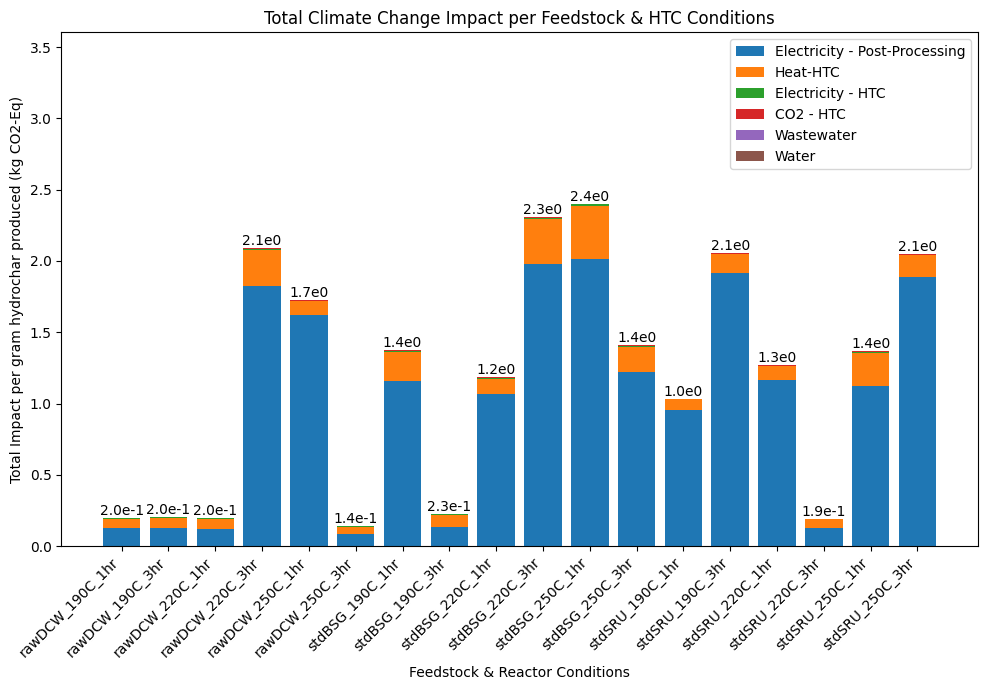

In [46]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'climate_change')

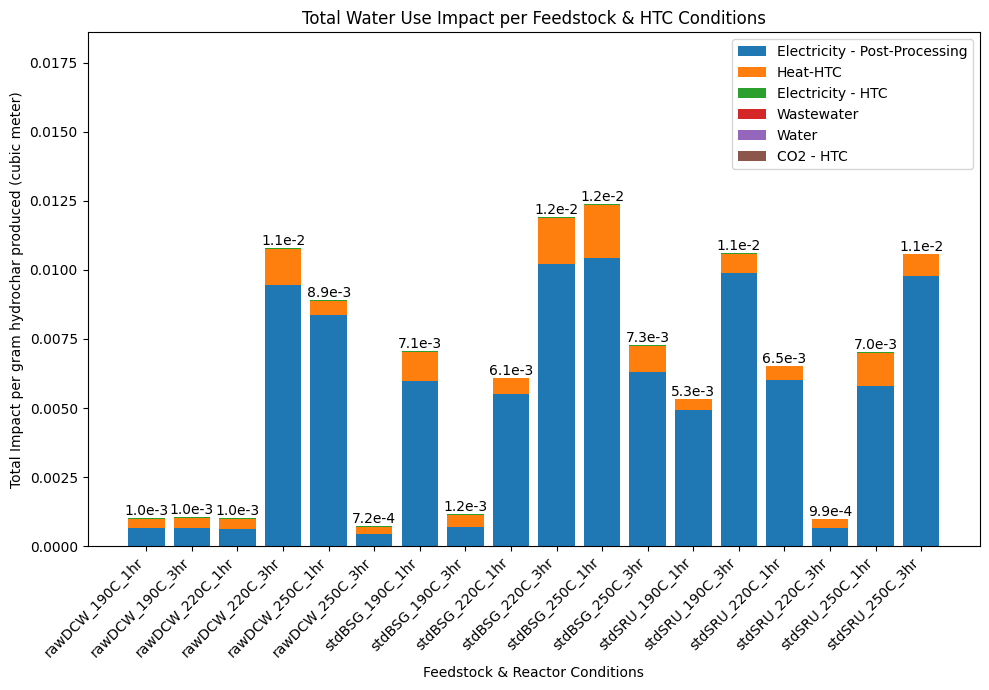

In [47]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'water_use')

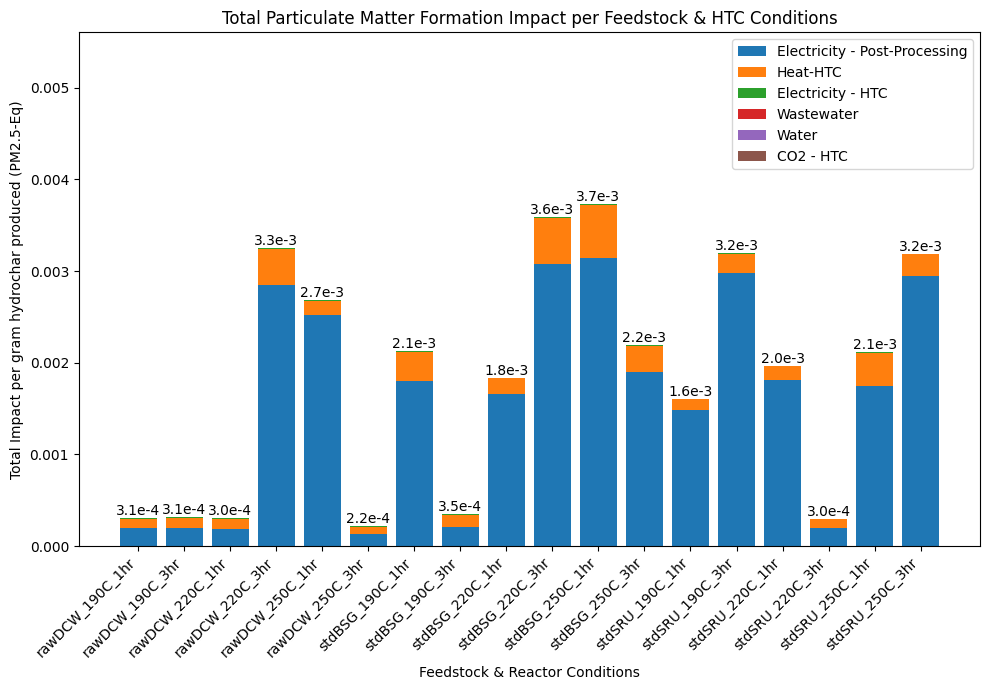

In [48]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'particulate_matter_formation')

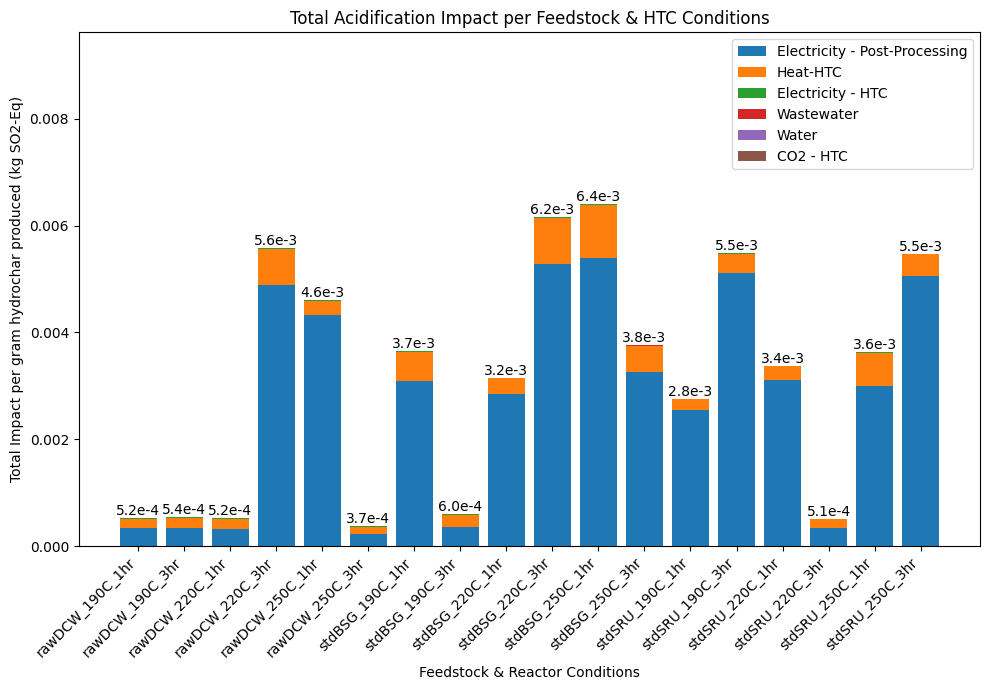

In [49]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'acidification')

#### 2.3.5: Plotting HHV Normalized Baseline LCA Results 
Plotting baseline LCA results normalized to HHV per gram of feedstock utilized. While each process produces a solid hydrochar, the properties of the hydrochar are different, which can affect the best utilization of the hydrochar after production. In this example, we'll focus on a coal replacement for electricity generation through analysis of a higher heating value (HHV). While the downstream process is not in the scope of this analysis and this does not consider the full complexity of post-processing needed for application, it does provide some initial insights towards considering future application.

If considering hydrochar for a different application such as a soil amendment, for carbon sequestration purposes, wastewater treatment, etc, other properties (i.e surface area) may be more applicable. 

In [53]:
# Replicating Baseline LCIA Manager for Re-Use
hc_hhv_lcia_manager = copy.deepcopy(baseline_lcia_manager)
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
for lcia in hc_hhv_lcia_list: 
    
    # Getting Relevant Feedstock HC HHV
    activity = [act for act in eidb if str(lcia.name) in act['name']][0]
    feedstock = activity['name']
    hc_hhv = get_parameter(feedstock, 'HHV_HC')
    
    # Determine normalization factor for getting per feedstock LCIA results
    # LCIA/feedstock = (LCIA / g hydrochar) * (MJ / kg hydrochar) * (1/1000)  
    normalization_factor = hc_hhv / 1000
    
    # Alternatively impact_categories = [attr for attr in lcia.__dict__ if attr != 'name']
    impact_categories = lcia.get_impact_categories()
    
    # Alternatively process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
    process_categories = lcia.get_process_categories()
    
    for impact_category in impact_categories:
        for process_category in process_categories: 
            # Multiply by 500 to mimic experimental conditions
            unit = lcia.get_impact_unit(impact_category, process_category)
            score = lcia.get_impact_score(impact_category, process_category) * normalization_factor 
            lcia.set_impact_score(impact_category, process_category, score, unit)
        
    
    print(lcia.name , "successfully updated in feedstock LCIA Manager.")

hydrochar production, rawDCW_190C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_250C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_190C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_250C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_250C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_250C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_190C_3hr successfully upd

In [56]:
# Identifying Exchanges of Interest 
exchange_names = []
activity = [act for act in eidb if 'hydrochar production' in act['name']][0]
for exc in activity.exchanges(): 
    exchange_names.append(exc.input)
    
# Gathering Process Categories  
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']

# Writing Data to an Excel File 
export_hydrochar_lcia_to_excel(hc_hhv_lcia_manager, exchange_names, process_categories, 'baseline-lcia/hhv_hc_lcia.xlsx')

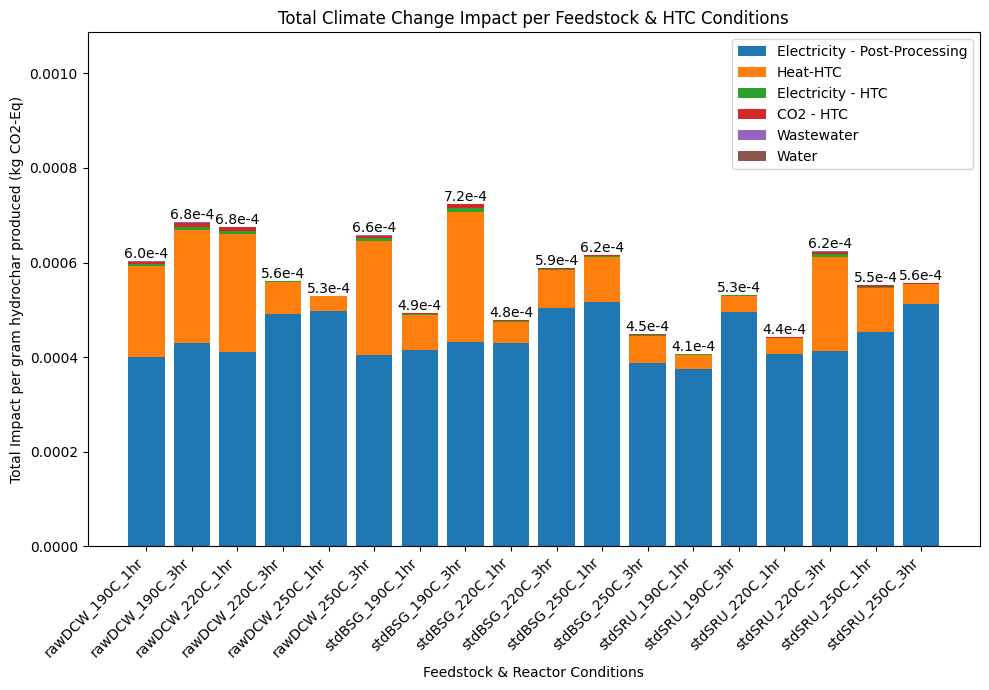

In [57]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'climate_change')

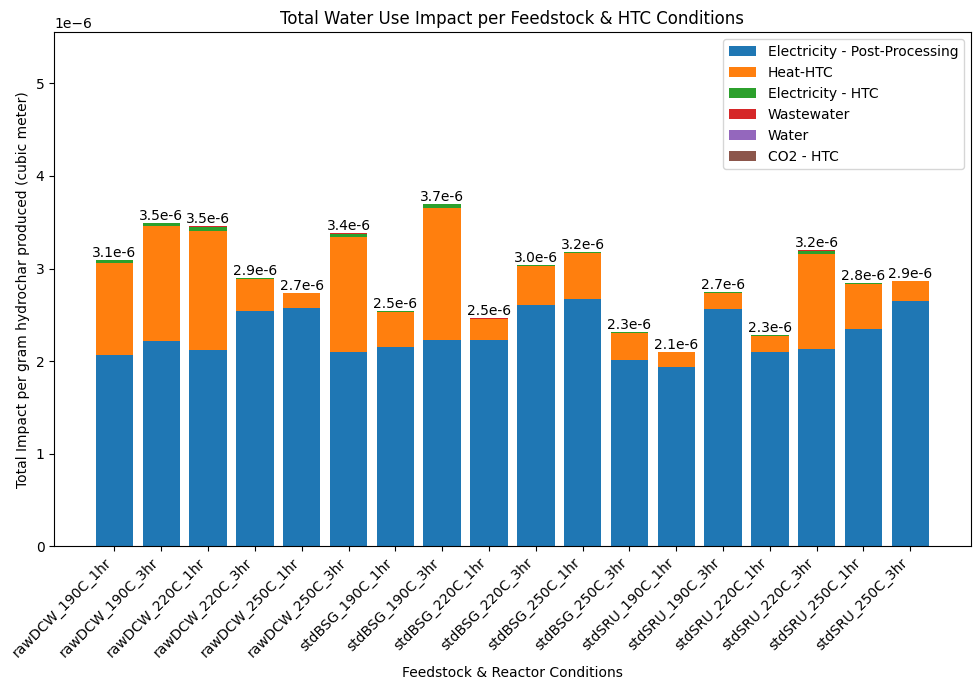

In [58]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'water_use')

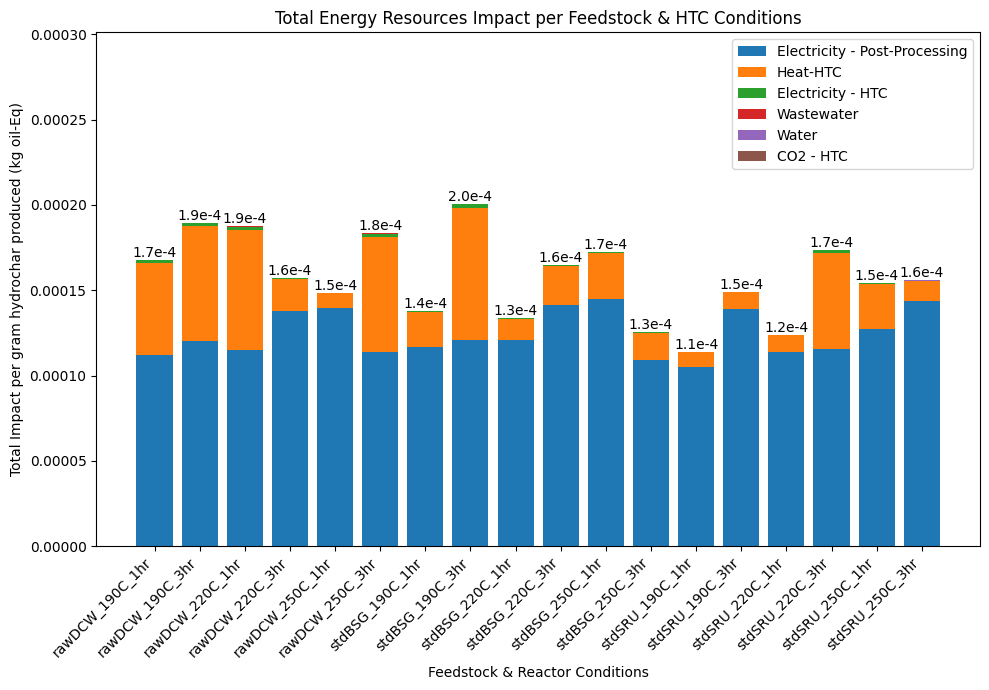

In [59]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'energy_resources')

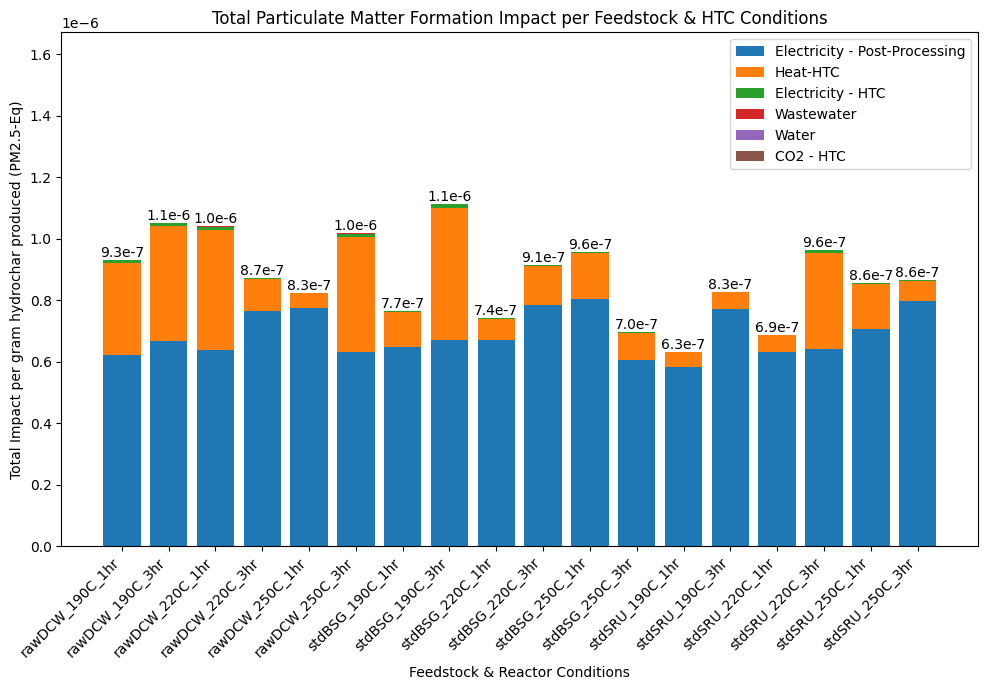

In [60]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'particulate_matter_formation')

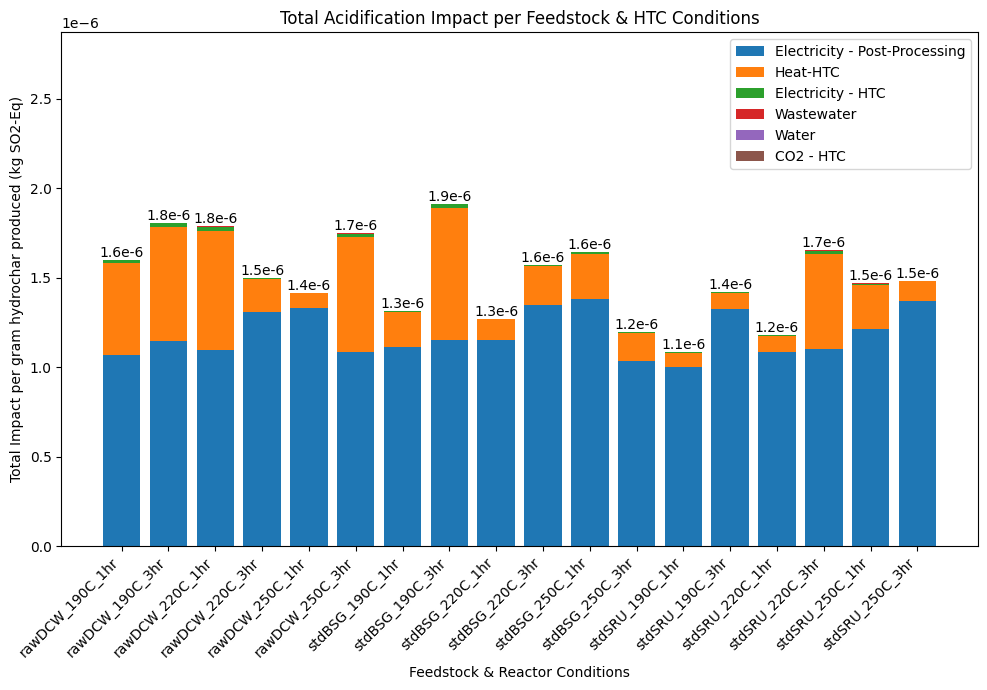

In [61]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'acidification')